In [ ]:
import pandas as pd
import numpy as np
qualtrix = pd.read_csv('/content/Hadar & Tomer Lexi_March 28, 2024_15.05.csv')

# average mood score

In [74]:
mood = pd.read_csv('Conversations.csv')
pre_columns = [col for col in mood.columns if col.startswith('pre_imsPre')]
post_columns = [col for col in mood.columns if col.startswith('post_imsPre')]
mood['pre_average'] = mood[pre_columns].mean(axis=1)
mood['post_average'] = mood[post_columns].mean(axis=1)
mood['mood_diff'] = mood['post_average'] - mood['pre_average']
# Create a new dataframe with user, pre_average, and post_average
mood_df = mood[['User','Agent', 'pre_average', 'post_average','mood_diff']]  # Assuming 'user' is the column name for users.

# avg message length

In [ ]:
from transformers import pipeline

Messages = pd.read_csv('Messages.csv') # the original file was deleted since it contains sensitive information

# Load the sentiment analysis pipeline with RoBERTa
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

# Assuming 'Messages' is your DataFrame
# Filter the DataFrame for rows where 'Role' is 'User'
user_messages = Messages[Messages['Role'] == 'user']

# Calculate the number of words in each message
user_messages['Word_Count'] = user_messages['Content'].str.split().apply(len)

# Define a function to analyze sentiment using RoBERTa
def analyze_sentiment_roberta(text):
    result = sentiment_pipeline(text)[0]  # Get the first (and only) result
    # Convert labels to a numerical score: negative -> -1, neutral -> 0, positive -> 1
    label_to_score = {'LABEL_0': -1, 'LABEL_1': 0, 'LABEL_2': 1}
    return label_to_score[result['label']]

# Calculate sentiment for each message
user_messages['Sentiment'] = user_messages['Content'].apply(analyze_sentiment_roberta)

# Group by 'User' and calculate the average word count and average sentiment for each user
# Group by 'User' and calculate the statistics for word count, and average sentiment for each user
average_metrics = user_messages.groupby('User').agg({
    'Word_Count': ['mean', 'max', 'min', 'median'],
    'Sentiment': 'mean',
    'Content': 'count'  # Count the number of messages per user
}).reset_index()



# Flatten the MultiIndex for columns and rename for clarity
average_metrics.columns = ['User', 'Average_Word_Count', 'Max_Word_Count', 'Min_Word_Count', 'Median_Word_Count', 'Average_Sentiment', 'Message_Count']
average_metrics.to_csv('message_metrics.csv', index=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

<ipython-input-3-8c4c7cb3bf69>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_messages['Word_Count'] = user_messages['Content'].str.split().apply(len)
<ipython-input-3-8c4c7cb3bf69>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_messages['Sentiment'] = user_messages['Content'].apply(analyze_sentiment_roberta)


In [75]:
average_metrics = pd.read_csv('message_metrics.csv')
merged_df = mood_df.merge(average_metrics, on='User', how='inner')


# qualtrix

In [76]:
crs_columns_to_negate = ['CRS_2_r', 'CRS_4_r', 'CRS_8_r', 'CRS_12_r']

# reversing values for specified CRS columns
for col in crs_columns_to_negate:
    if col in qualtrix.columns:
        qualtrix[col] = 8-qualtrix[col]

ddi = [col for col in qualtrix.columns if col.startswith('DDI')]
agency = [col for col in qualtrix.columns if col.startswith('AGN')]
experience = [col for col in qualtrix.columns if col.startswith('EXP')]
crs = [col for col in qualtrix.columns if col.startswith('CRS')]
psd = [col for col in qualtrix.columns if col.startswith('PSD')]



qualtrix['DDI_average'] = qualtrix[ddi].mean(axis=1)
qualtrix['AGN_average'] = qualtrix[agency].mean(axis=1)
qualtrix['EXP_average'] = qualtrix[experience].mean(axis=1)
qualtrix['CRS_average'] = qualtrix[crs].mean(axis=1)
qualtrix['PSD_average'] = qualtrix[psd].mean(axis=1)
qualtrix.rename(columns={'Q3': 'User'}, inplace=True)
qualtrix_df = qualtrix[['User','DDI_average','AGN_average','EXP_average','CRS_average','PSD_average']]

In [77]:
merged_df = merged_df.merge(qualtrix_df, on='User', how='inner')


# Statistical Test and Box plot

In [70]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu
import matplotlib.pyplot as plt

def analyze_measurement(data, measurement='', col = 'Agent', group1 = 'Target-focused Agent', group2 = 'Problem-focused Agent', calc_groups=True, group1_data = None, group2_data=None):
    """
    Analyze the given measurement by calculating mean, standard deviation,
    performing statistical tests between two groups, and creating a boxplot.

    Parameters:
    - data: DataFrame containing the measurement data.
    - measurement: The name of the measurement column in the DataFrame.
    - col: The name of the column containing group labels.
    - group1: The label of the first group.
    - group2: The label of the second group.

    Returns:
    - A dictionary containing the mean, standard deviation, and p-value for the statistical test.
    """
    # Filter data by group
    if calc_groups:
      group1_data = data[data[col] == group1][measurement]
      group2_data = data[data[col] == group2][measurement]


    # Calculate mean and standard deviation for each group
    group1_mean = np.mean(group1_data)
    group1_std = np.std(group1_data, ddof=1)

    group2_mean = np.mean(group2_data)
    group2_std = np.std(group2_data, ddof=1)

    # Perform statistical test
    if group1_data.shape[0] >= 30 and group2_data.shape[0] >= 30:
        # Use t-test for large samples
        stat, p_value = ttest_ind(group1_data, group2_data, equal_var=False)
    else:
        # Use Mann-Whitney U test for small samples
        stat, p_value = mannwhitneyu(group1_data, group2_data)

    # Create boxplot
    plt.figure(figsize=(8, 6))
    plt.boxplot([group1_data, group2_data], labels=[group1, group2])
    plt.ylabel(measurement)
    if measurement != 'mood_diff':
      plt.title(f'Boxplot of {measurement} for {group1} and {group2}')
    else:
      plt.title(f'Boxplot of IMS mean diff - post vs Pre conversation for {group1} and {group2}')
    plt.show()
    output = {
         f'{group1}_mean': group1_mean,
        f'{group1}_std': group1_std,
        f'{group2}_mean': group2_mean,
        f'{group2}_std': group2_std,
        'p_value': p_value
    }
    # Return results
    print(output)






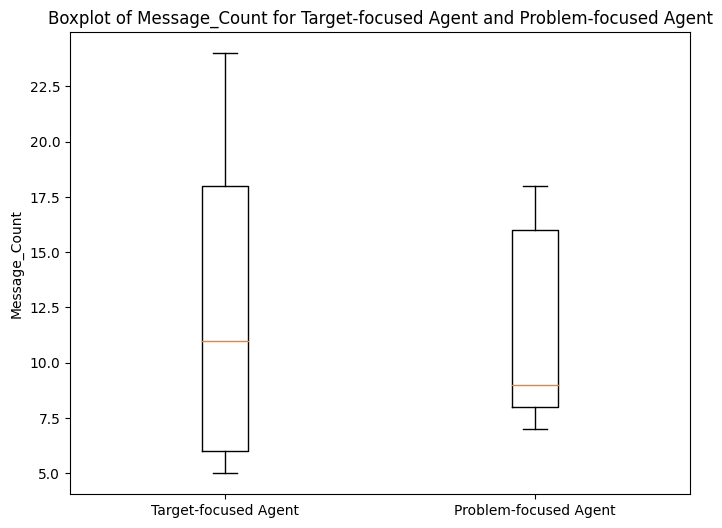

{'Target-focused Agent_mean': 12.636363636363637, 'Target-focused Agent_std': 7.338565626506686, 'Problem-focused Agent_mean': 11.444444444444445, 'Problem-focused Agent_std': 4.419024527854284, 'p_value': 1.0}


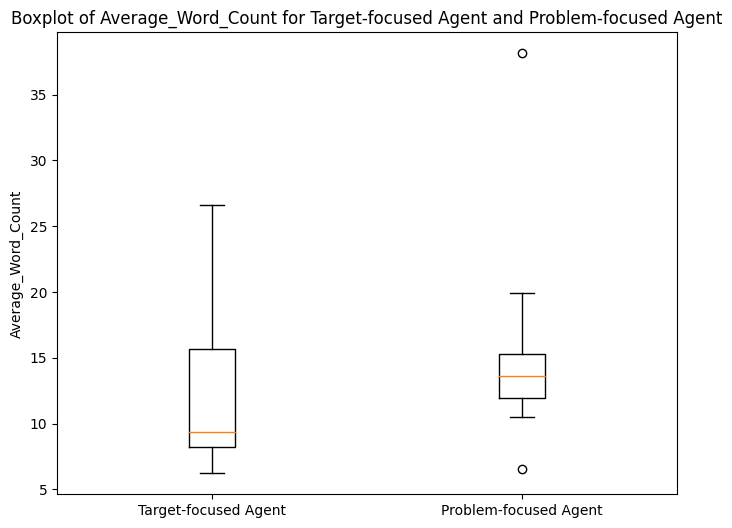

{'Target-focused Agent_mean': 12.613897226393709, 'Target-focused Agent_std': 6.224201381253653, 'Problem-focused Agent_mean': 15.942752100840336, 'Problem-focused Agent_std': 9.073639638776951, 'p_value': 0.3619347669211923}


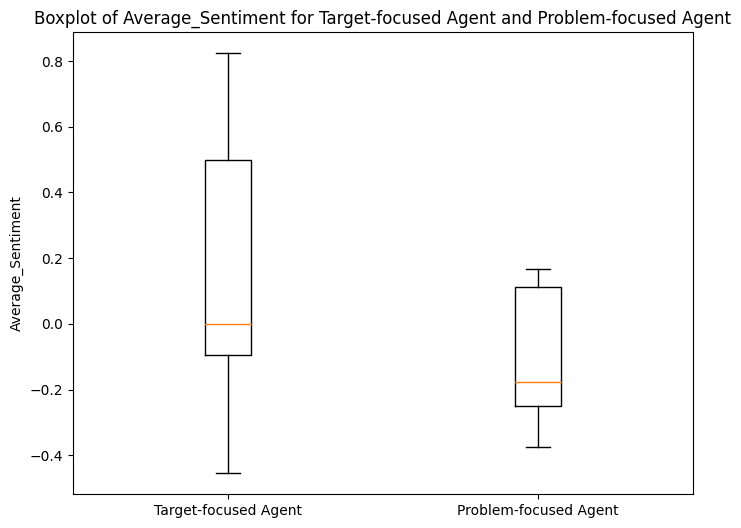

{'Target-focused Agent_mean': 0.19285573700152933, 'Target-focused Agent_std': 0.4256428362432276, 'Problem-focused Agent_mean': -0.09687856624131136, 'Problem-focused Agent_std': 0.200728398274481, 'p_value': 0.11007577052748961}


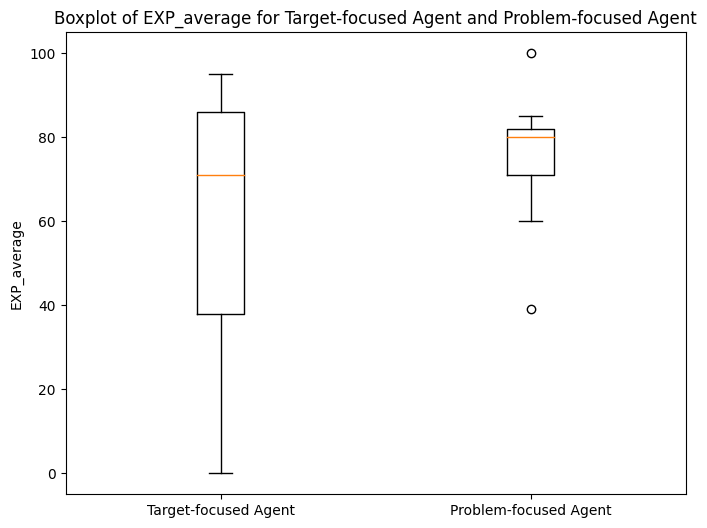

{'Target-focused Agent_mean': 61.54545454545455, 'Target-focused Agent_std': 31.715496642378582, 'Problem-focused Agent_mean': 75.0, 'Problem-focused Agent_std': 17.233687939614086, 'p_value': 0.4241583595376336}


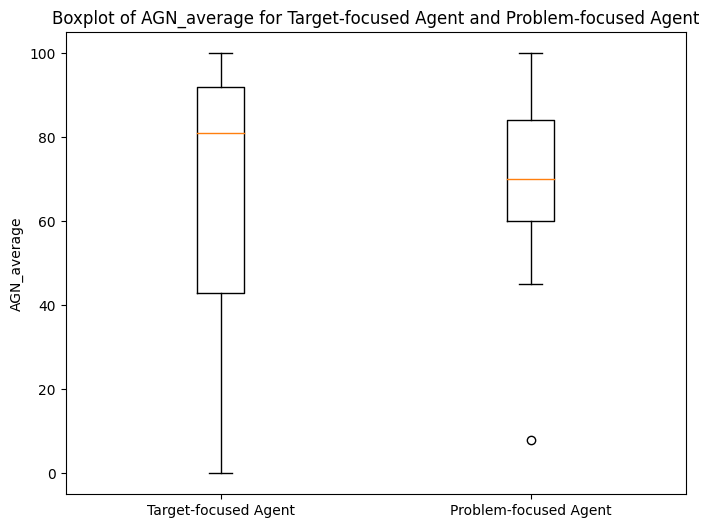

{'Target-focused Agent_mean': 68.36363636363636, 'Target-focused Agent_std': 32.134942748580485, 'Problem-focused Agent_mean': 67.44444444444444, 'Problem-focused Agent_std': 27.937927227655557, 'p_value': 0.8491924768268733}


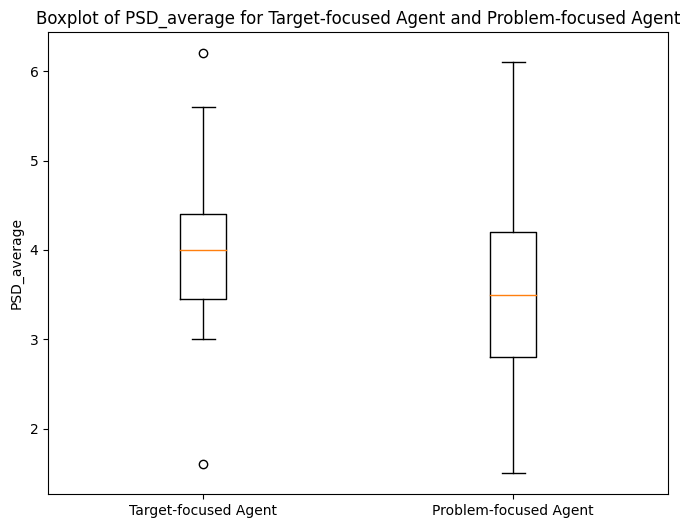

{'Target-focused Agent_mean': 4.00909090909091, 'Target-focused Agent_std': 1.2356816300767326, 'Problem-focused Agent_mean': 3.688888888888889, 'Problem-focused Agent_std': 1.5070206073943084, 'p_value': 0.4931476790457543}


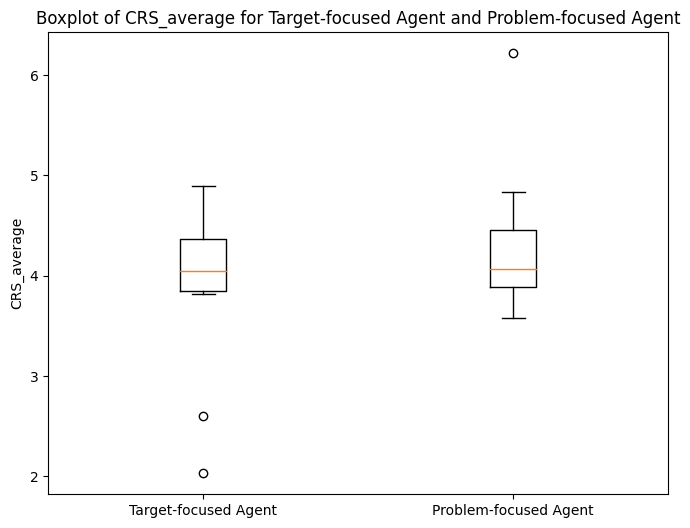

{'Target-focused Agent_mean': 3.8945221445221447, 'Target-focused Agent_std': 0.857189897485641, 'Problem-focused Agent_mean': 4.336182336182336, 'Problem-focused Agent_std': 0.8135415434626471, 'p_value': 0.5686660222491573}


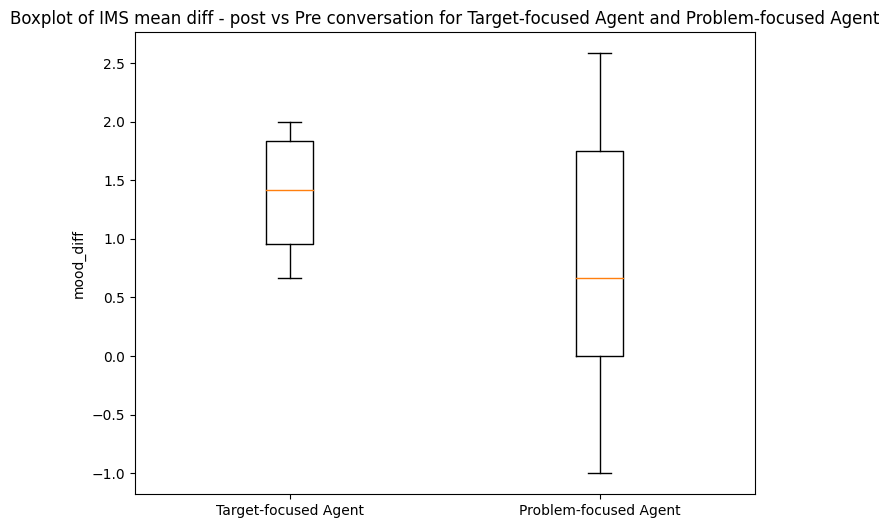

{'Target-focused Agent_mean': 1.3787878787878787, 'Target-focused Agent_std': 0.4864320729723335, 'Problem-focused Agent_mean': 0.7685185185185186, 'Problem-focused Agent_std': 1.1124124323977536, 'p_value': 0.09389407246990174}


In [71]:
measurements = [
    'Message_Count', 'Average_Word_Count','Average_Sentiment', 'EXP_average', 'AGN_average',
    'PSD_average', 'CRS_average'
]

for measurement in measurements:
    analyze_measurement(merged_df, measurement)

analyze_measurement(mood_df, 'mood_diff')


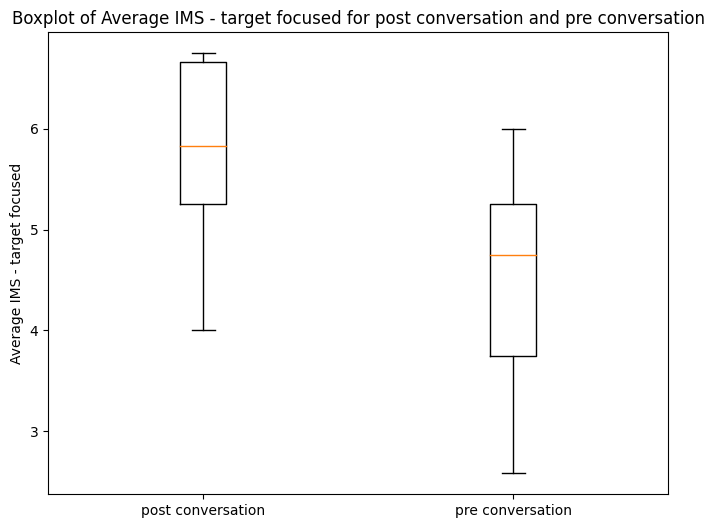

{'post conversation_mean': 5.878787878787878, 'post conversation_std': 0.900126253770699, 'pre conversation_mean': 4.500000000000001, 'pre conversation_std': 1.0814085465005556, 'p_value': 0.007740253479575836}


In [72]:
target_df = mood_df[mood_df['Agent'] =='Target-focused Agent']
problem_df = mood_df[mood_df['Agent']=='Problem-focused Agent']
analyze_measurement(mood_df,measurement='Average IMS - target focused',group1 = 'post conversation',group2='pre conversation',group1_data = target_df['post_average'],group2_data= target_df['pre_average'],calc_groups=False)

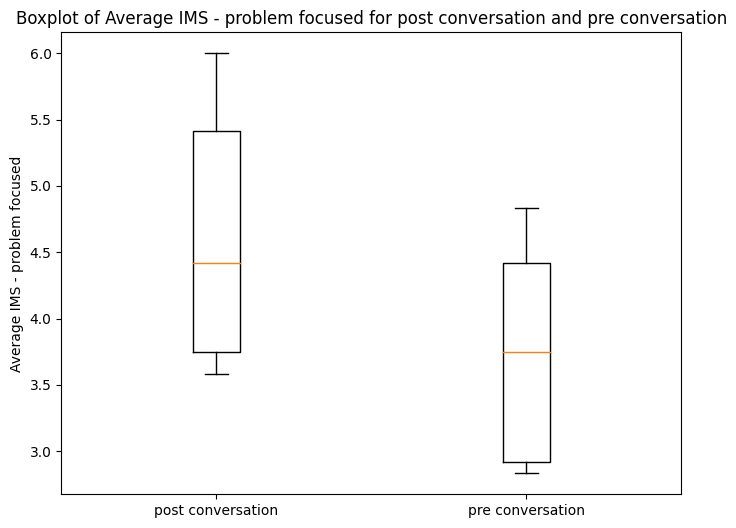

{'post conversation_mean': 4.574074074074074, 'post conversation_std': 0.9551072914974553, 'pre conversation_mean': 3.8055555555555554, 'pre conversation_std': 0.7905694150420949, 'p_value': 0.14366535480029924}


In [73]:
analyze_measurement(problem_df,measurement='Average IMS - problem focused',group1 = 'post conversation',group2='pre conversation', group1_data=problem_df['post_average'], group2_data=problem_df['pre_average'], calc_groups=False)


# Correlation


In [62]:
import pandas as pd
from scipy.stats import pearsonr

def correlate_interaction_metrics(data, interaction_metrics, outcome_measures):
    """
    Correlate interaction metrics with outcome measures such as perceived self-disclosure and comforting responses.

    Parameters:
    - data: DataFrame containing the interaction metrics and outcome measures.
    - interaction_metrics: List of column names representing interaction metrics.
    - outcome_measures: List of column names representing outcome measures.

    Returns:
    - A dictionary containing the correlation coefficients for each pair of interaction metric and outcome measure.
    """
    correlations = {}
    for metric in interaction_metrics:
        for outcome in outcome_measures:
            correlation_coefficient, p_value = pearsonr(data[metric], data[outcome])
            correlations[f'{metric}_vs_{outcome}'] = {
                'correlation_coefficient': correlation_coefficient,
                'p_value': p_value
            }
    return correlations

interaction_metrics = ['Message_Count', 'Average_Sentiment','Average_Word_Count']
outcome_measures = ['PSD_average', 'CRS_average']

correlations = correlate_interaction_metrics(merged_df, interaction_metrics, outcome_measures)
print(correlations)

{'Message_Count_vs_PSD_average': {'correlation_coefficient': -0.02481424049602111, 'p_value': 0.9172942405622807}, 'Message_Count_vs_CRS_average': {'correlation_coefficient': -0.17717828223446314, 'p_value': 0.4548895150253797}, 'Average_Sentiment_vs_PSD_average': {'correlation_coefficient': 0.48486478449227677, 'p_value': 0.030251689107986066}, 'Average_Sentiment_vs_CRS_average': {'correlation_coefficient': 0.09139614948219323, 'p_value': 0.7015555682550316}, 'Average_Word_Count_vs_PSD_average': {'correlation_coefficient': -0.06731330569172111, 'p_value': 0.7779661546189808}, 'Average_Word_Count_vs_CRS_average': {'correlation_coefficient': 0.08471509529619865, 'p_value': 0.7225129253224176}}


#Converstion Engagment -Average Word count distribution

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_conversation_engagement(data, col, group1 = 'Target-focused Agent', group2 = 'Problem-focused Agent'):
    """
    Analyze conversation engagement by calculating the distribution of message lengths
    and comparing these metrics between two engagement strategies.

    Parameters:
    - data: DataFrame containing the message data with columns 'group' and 'message_length'.
    - col: The name of the column containing group labels.
    - group1: The label of the first group.
    - group2: The label of the second group.

    Returns:
    - None
    """
    # Filter data by group
    group1_data = data[data[col] == group1]['Average_Word_Count']
    group2_data = data[data[col] == group2]['Average_Word_Count']

    # Plot distribution of message lengths for each group
    plt.figure(figsize=(10, 6))
    sns.kdeplot(group1_data, label=group1, fill=True)
    sns.kdeplot(group2_data, label=group2, fill=True)
    plt.xlabel('Message Length')
    plt.ylabel('Density')
    plt.title('Distribution of Message Lengths')
    plt.legend()
    plt.show()

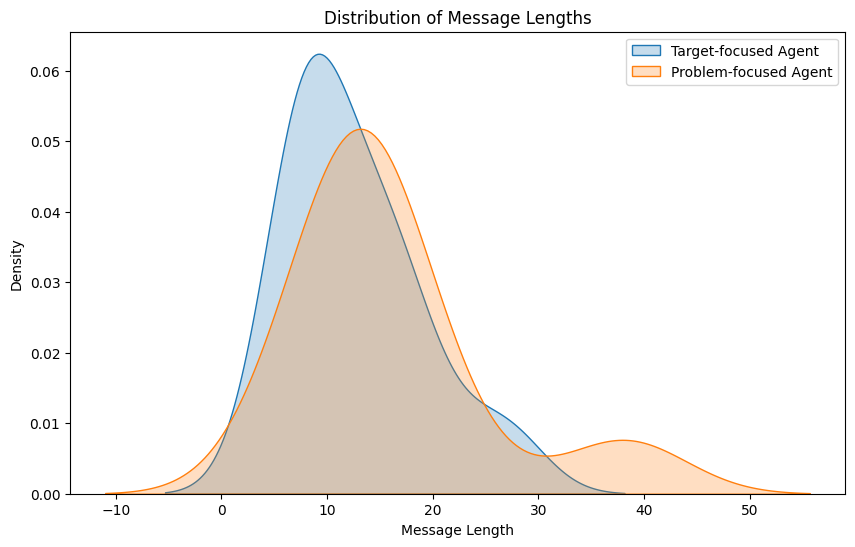

In [ ]:
analyze_conversation_engagement(merged_df,'Agent')

#Scatter Plot

In [14]:
import matplotlib.pyplot as plt

def plot_scatter_groups(x, y, groups, x_label, y_label, group_labels=None, colors=None):
    """
    Creates a scatter plot for multiple groups in separate colors.

    Parameters:
    - x: List or array of x-axis values.

    - y: List or array of y-axis values.
    - groups: List or array indicating the group of each point.
    - group_labels: Dictionary mapping group values to labels (optional).
    - colors: Dictionary mapping group values to colors (optional).
    """
    # Set default colors if not provided
    if colors is None:
        colors = {group: plt.cm.tab10(i) for i, group in enumerate(set(groups))}

    # Set default labels if not provided
    if group_labels is None:
        group_labels = {group: f'{group}' for group in set(groups)}

    # Plot the points for each group
    for group in set(groups):
        mask = [g == group for g in groups]
        plt.scatter([x[i] for i in range(len(x)) if mask[i]],
                    [y[i] for i in range(len(y)) if mask[i]],
                    color=colors[group], label=group_labels[group])

    # Add labels and legend
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()

    # Show the plot
    plt.show()

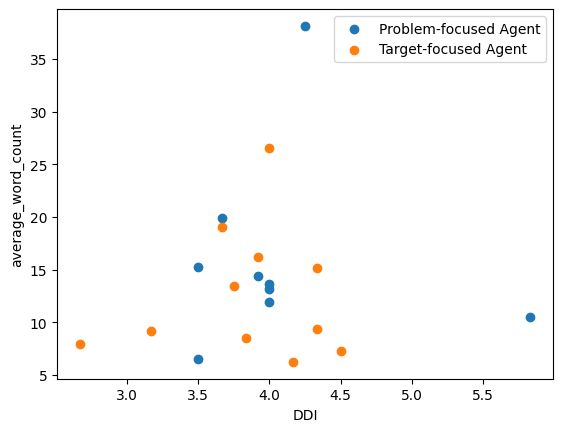

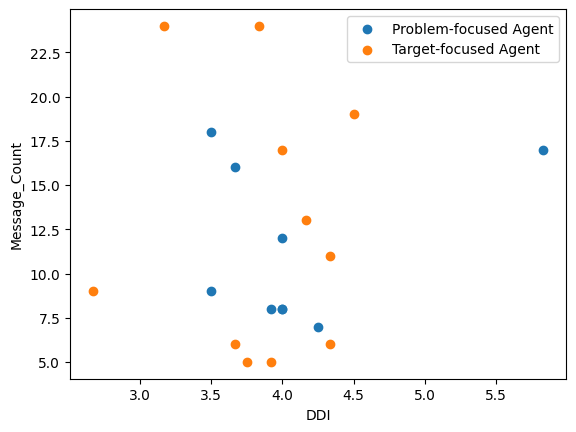

In [78]:
x_axis= merged_df["DDI_average"]
y_axis= merged_df["Average_Word_Count"]
y_axis2 = merged_df["Message_Count"]
groups=merged_df["Agent"]
plot_scatter_groups(x_axis,y_axis,groups , x_label="DDI", y_label= "average_word_count")
plot_scatter_groups(x_axis,y_axis2,groups , x_label="DDI", y_label= "Message_Count")